<a href="https://colab.research.google.com/github/adalbertii/Seci-konwolucyjne/blob/main/keras_convolutional_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---



**# Budowa konwolucyjnych sieci neuronowych - przypadek klasyfikacji binarnej**





Wykorzystanie biblioteki Keras

> Sieci konwolucyjne uczą się lokalnych wzorców. Wzorce rozpoznawane przez sieć konwolucyjną są niezależne od ich położenia na obrazie.

 > Zaletą CNN jest możliwość uczenia przestrzennej hierarchii wzorców.
 Pierwsze warstwy uczą się małych lokalnych wzorców, takich jak krawędzie, a kolejne warstwy uczą się większych struktur składających się z elementów rozpoznanych przez warstwy początkowe.

**# Importowanie niezbędnych bibliotek**


In [ ]:
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

**# Pobieranie danych treningowych i testowych**

Pobierzemy dane z magazynu Amazon S3.

Nazwa bucketu to: `ml-repository-crackers`.

Spakowany plik `dogs-vs-cats.zip` ma nieco ponad 812 MB i jest przechowywany w regionie UE (Irlandia).

In [ ]:
%%bash
#rm -rf /content/*

pwd
wget --output-document=cats_and_dogs.zip --quiet https://ml-repository-krakers.s3-eu-west-1.amazonaws.com/kaggle+/cats_and_dogs/dogs-vs-cats.zip
ls

/content
cats_and_dogs
cats_and_dogs.zip
kaggle_original_data
sample_data
test1
test1.zip
wmi_small_model_1.h5
wmi_small_model_2.h5


**# Rozpakowywanie danych**

In [ ]:
%%bash
unzip cats_and_dogs.zip
# rm -rf cats_and_dogs.zip

rm -rf sampleSubmission.csv

unzip -q train.zip -d /content/kaggle_original_data
rm -rf train.zip
cp /content/kaggle_original_data/train/* /content/kaggle_original_data/
rm -rf /content/kaggle_original_data/train

unzip -q /content/test1.zip
# rm -rf test1.zip
# rm -rf cats_and_dogs.zip
ls

Archive:  cats_and_dogs.zip
  inflating: sampleSubmission.csv    
  inflating: train.zip               
  inflating: mpleSubmission.csv      


replace test1.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: error:  invalid response [# rm -rf ]
replace test1.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: error:  invalid response [cats_and_]
replace test1.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: error:  invalid response [dogs.zip]
replace test1.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: error:  invalid response [{ENTER}]
replace test1.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: new name: 

**# Przygotowanie odpowiedniej struktury katalogów**

Dane będą przechowywane w katalogu:

> `/content/cats_and_dogs`.

Podzielimy ten katalog na trzy podkatalogi:
 * train
 * valid
 * test

W zestawie treningowym umieścimy 2000 próbek (1000 zdjęć psów i 1000 zdjęć kotów), 1000 próbek (500 zdjęć psów i 500 zdjęć kotów) trafi do zestawu walidacyjnego, a ostatnie 1000 próbek (500 zdjęć psów i 500 zdjęć kotów) trafi do zestawu testowego.

In [ ]:

original_dataset_dir = '/content/kaggle_original_data'

base_dir = '/content/cats_and_dogs'

if not os.path.exists(base_dir):
    os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

for directory in (train_dir, valid_dir, test_dir):
    if not os.path.exists(directory):
        os.mkdir(directory)

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

valid_cats_dir = os.path.join(valid_dir, 'cats')
valid_dogs_dir = os.path.join(valid_dir, 'dogs')

test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')

dirs = [train_cats_dir, train_dogs_dir, valid_cats_dir, valid_dogs_dir, test_cats_dir, test_dogs_dir]

for directory in dirs:
    if not os.path.exists(directory):
        os.mkdir(directory)


# rozdzielenie zdjęc
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(valid_cats_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(valid_dogs_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)


**# Sprawdzanie poprawności podziału**


In [ ]:
print('Number of cats - training set', len(os.listdir(train_cats_dir)))
print('Number of cats - validation set', len(os.listdir(valid_cats_dir)))
print('Number of cats - test set', len(os.listdir(test_cats_dir)))

print('Number of dogs - training set', len(os.listdir(train_dogs_dir)))
print('Number of dogs - validation set', len(os.listdir(valid_dogs_dir)))
print('Number of dogs - test set', len(os.listdir(test_dogs_dir)))


Number of cats - training set 1000
Number of cats - validation set 500
Number of cats - test set 500
Number of dogs - training set 1000
Number of dogs - validation set 500
Number of dogs - test set 500


**# Spójrzmy na przykładowe zdjęcia - koty i psy**
> Wskazówka: suwak po prawej stronie służy do wyboru innego indeksu obrazu.

In [ ]:
import PIL
import PIL.Image

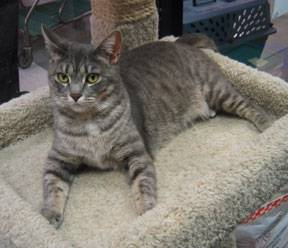

In [ ]:
index = 509 #@param {type:'slider', min:0, max:999}
img_path = '/content/cats_and_dogs/train/cats/cat.' + str(index) +'.jpg'
PIL.Image.open(img_path)

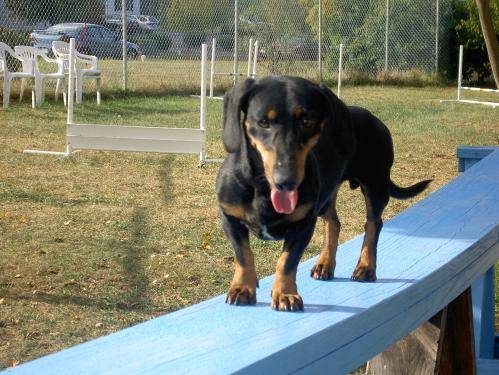

In [ ]:
index = 285 #@param {type:'slider', min:0, max:999}
img_path = '/content/cats_and_dogs/train/dogs/dog.' + str(index) +'.jpg'
PIL.Image.open(img_path)

**# Definicja funkcji pomocniczych**

In [ ]:
def make_accuracy_plot(history):
    """
    Funkcja zwraca wykres dokładności modelu na zestawie treningowym
    i walidacyjnym.
    """
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(10, 8))
    plt.plot(epochs, acc, label='Accuracy of training', marker='o')
    plt.plot(epochs, val_acc, label='Validation accuracy', marker='o')
    plt.legend()
    plt.title('Accuracy of training and validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

def make_loss_plot(history):
    """
    Funkcja zwraca wykres strat modelu na zestawie treningowym
    i walidacyjnym.
    """
    loss, val_loss = history.history['loss'], history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(10, 8))
    plt.plot(epochs, loss, label='Training loss', marker='o')
    plt.plot(epochs, val_loss, label='Validation loss', marker='o')
    plt.legend()
    plt.title('Loss of training and validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()


**# Budowanie modelu**


> Warstwa Conv2D jest warstwą splotową, w której należy określić co najmniej trzy parametry:
- liczbę filtrów, które będą wyodrębniać cechy,
- rozmiar jądra (rozmiar okna konwolucji, zwykle 3x3 lub 5x5) i
- funkcja aktywacji (najczęściej używana funkcja `relu`).

Ponadto w pierwszej warstwie należy określić parametr `input_shape`, który przyjmuje rozmiar danych wejściowych. W naszym przypadku `(150, 150, 3)`.

Pierwsze dwie wartości określają szerokość i wysokość obrazu, podczas gdy trzecia określa głębię kolorów, w tym przypadku 3.

> Warstwa MaxPooling2D jest operacją skalowania. Mówiąc prościej, polega ona na zmniejszeniu wymiarowości poprzez przejście przez obraz z oknami ekstrakcji, które zwracają maksymalną zaobserwowaną wartość w danym oknie (zwykle rozmiar okna 2x2, z krokiem przesunięcia 2), pomagając w ten sposób zmniejszyć rozmiar danych wejściowych do następnej warstwy o połowę, co znacznie przyspiesza proces uczenia się.

> Warstwa Flatten spłaszcza  dane w celu połączenia ich z gęstymi warstwami modelu.

Ostatnią funkcją aktywacji będzie funkcja `sigmoid`, która zwróci prawdopodobieństwo przynależności obrazu do określonej klasy.

In [ ]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(units=512, activation='relu'))
model.add(layers.Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 36, 36, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 17, 17, 128)      


**# Kompilacja modelu**



In [ ]:
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4),
             loss='binary_crossentropy',
             metrics=['accuracy'])

**# Przetwarzanie danych do modelu**

Ponieważ nasze dane są nieznormalizowane (różne rozmiary obrazów), musimy je przetworzyć tak, aby były przedstawione w postaci tensorów wartości zmiennoprzecinkowych (float).

Dane są obecnie w plikach JPG. W procesie przetwarzania danych pomoże nam klasa `ImageDataGenerator` wbudowana w `Keras`.
Wszystkie obrazy z zestawów treningowych i walidacyjnych zostaną przeskalowane do rozmiaru 150x150 pikseli.

**# W skrócie:**
- pobieramy pliki w formacie JPG
- dekodujemy je z formatu JPG do siatki pikseli w formacie RGB
- zapisujemy dane w formacie tensora liczb zmiennoprzecinkowych
- przeskalowywujemy wartości pikseli do zakresu [0, 1] (sieci neuronowe lepiej radzą sobie z małymi wartościami wejściowymi)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# Skalujemy wszystkie obrazy o współczynnik 1/255.
train_datagen = ImageDataGenerator(rescale=1./255.)
valid_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                   target_size=(150, 150),
                                                   batch_size=20,
                                                   class_mode='binary')

valid_generator = valid_datagen.flow_from_directory(directory=valid_dir,
                                                   target_size=(150, 150),
                                                   batch_size=20,
                                                   class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


**# Sprawdzanie prawidłowego kształtu danych treningowych**

In [ ]:
for data_batch, labels_batch in train_generator:
    print('Batch data shape:', data_batch.shape)
    print('Batch data label shape:', labels_batch.shape)
    break

Batch data shape: (20, 150, 150, 3)
Batch data label shape: (20,)


**# Proces uczenia modelu**

Zapis wyuczonego modelu do pliku wmi_small_model_1.h5



In [ ]:
import time

tic = time.time()
history = model.fit_generator(generator=train_generator,
                             steps_per_epoch=100,
                             epochs=15,
                             validation_data=valid_generator,
                             validation_steps=50)

toc = time.time()
print('Czas procesu uczenia modelu: {}'.format(toc - tic))
model.save('wmi_small_model_1.h5')

Epoch 1/30
100/100 [==============================] - 7s 62ms/step - loss: 0.6909 - accuracy: 0.5230 - val_loss: 0.6765 - val_accuracy: 0.5380
Epoch 2/30
100/100 [==============================] - 6s 59ms/step - loss: 0.6676 - accuracy: 0.5855 - val_loss: 0.6739 - val_accuracy: 0.5430
Epoch 3/30
100/100 [==============================] - 6s 59ms/step - loss: 0.6396 - accuracy: 0.6275 - val_loss: 0.6348 - val_accuracy: 0.6200
Epoch 4/30
100/100 [==============================] - 5s 50ms/step - loss: 0.6029 - accuracy: 0.6610 - val_loss: 0.6813 - val_accuracy: 0.5620
Epoch 5/30
100/100 [==============================] - 6s 59ms/step - loss: 0.5757 - accuracy: 0.7060 - val_loss: 0.6028 - val_accuracy: 0.6780
Epoch 6/30
100/100 [==============================] - 6s 59ms/step - loss: 0.5446 - accuracy: 0.7205 - val_loss: 0.5904 - val_accuracy: 0.6810
Epoch 7/30
100/100 [==============================] - 5s 50ms/step - loss: 0.5321 - accuracy: 0.7290 - val_loss: 0.5779 - val_accuracy: 0.6850

**# Wykres dokładności modelu**

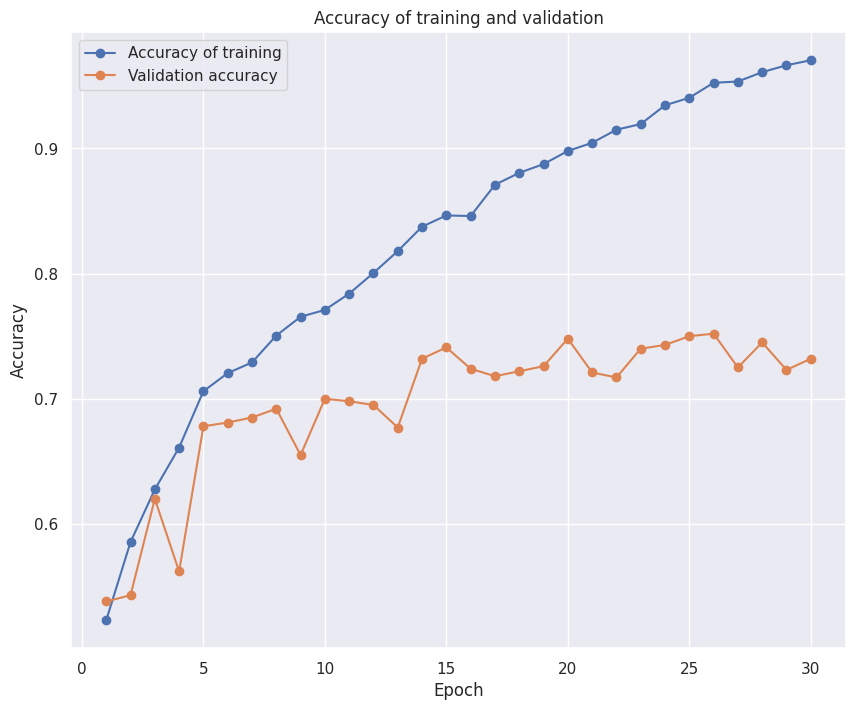

In [ ]:
make_accuracy_plot(history)

**# Wykres strat modelu**

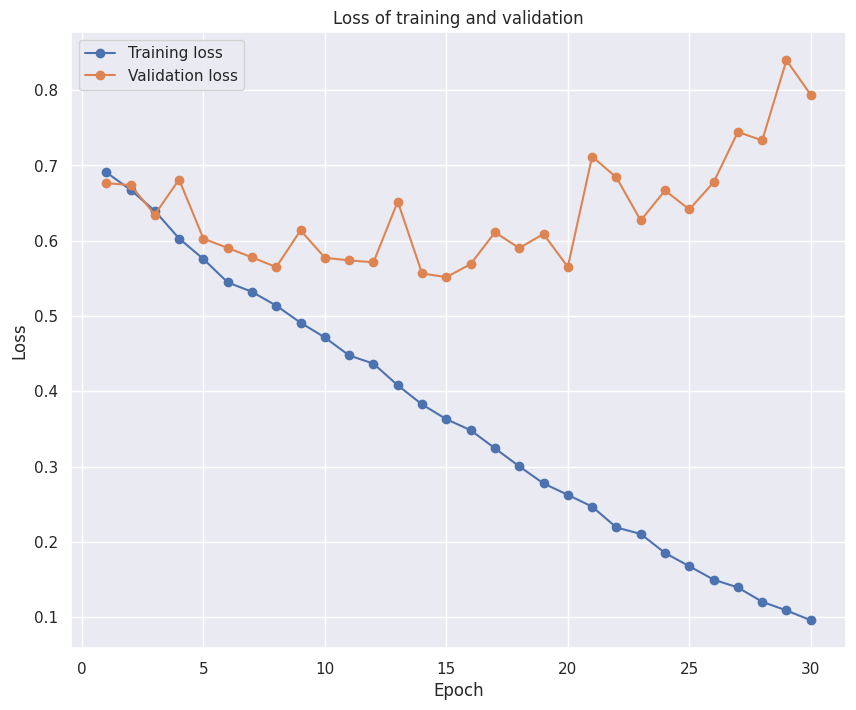

In [ ]:
make_loss_plot(history)

In [ ]:
# dane walidacyjne są wyłczone z tego procesu !!!
test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_directory(test_dir,
                                                 target_size=(150, 150),
                                                 batch_size=20,
                                                 class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('Testing Accuracy:', test_acc)

Found 1000 images belonging to 2 classes.
Testing Accuracy: 0.7450000047683716


**########################################################################**

**# Uzupełnienie topoligii modelu o warstwę Augmentacji danych**

Szczególnie przydatne w przypadku niewystarczających danych szkoleniowych.

Polega na różnych przekształceniach danych wejściowych poprzez operacje takie jak przycinanie, obracanie lub powiększanie w celu wygenerowania nowych danych wejściowych.




**# Budowa modelu z warstwa augmentacyjną (wykorzystanie topologi modelu z wcześniejszego etapu)**

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(units=512, activation='relu'))
model.add(layers.Dense(units=1, activation='sigmoid'))

model.summary()

model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 36, 36, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 17, 17, 128)      

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255.,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

# !!!! dane walidacyjne nie podlegają procesowi augmentacji

valid_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                   target_size=(150, 150),
                                                   batch_size=20,
                                                   class_mode='binary')

valid_generator = valid_datagen.flow_from_directory(directory=valid_dir,
                                                   target_size=(150, 150),
                                                   batch_size=20,
                                                   class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.



### Model training

In [ ]:
history = model.fit_generator(generator=train_generator,
                             steps_per_epoch=100,
                             epochs=50,
                             validation_data=valid_generator,
                             validation_steps=50)

toc = time.time()
print('Czas procesu uczenia modelu: {}'.format(toc - tic))
model.save('wmi_small_model_1.h5')

Epoch 1/25
100/100 [==============================] - 17s 155ms/step - loss: 0.7074 - accuracy: 0.4850 - val_loss: 0.6927 - val_accuracy: 0.5260
Epoch 2/25
100/100 [==============================] - 16s 159ms/step - loss: 0.6938 - accuracy: 0.5020 - val_loss: 0.6887 - val_accuracy: 0.5170
Epoch 3/25
100/100 [==============================] - 16s 155ms/step - loss: 0.6891 - accuracy: 0.5660 - val_loss: 0.6661 - val_accuracy: 0.6090
Epoch 4/25
100/100 [==============================] - 17s 167ms/step - loss: 0.6786 - accuracy: 0.5810 - val_loss: 0.7815 - val_accuracy: 0.5020
Epoch 5/25
100/100 [==============================] - 16s 159ms/step - loss: 0.6720 - accuracy: 0.5825 - val_loss: 0.6307 - val_accuracy: 0.6370
Epoch 6/25
100/100 [==============================] - 19s 193ms/step - loss: 0.6684 - accuracy: 0.5955 - val_loss: 0.6754 - val_accuracy: 0.5610
Epoch 7/25
100/100 [==============================] - 19s 189ms/step - loss: 0.6470 - accuracy: 0.6205 - val_loss: 0.6051 - val_ac

**# Zapisujemy model do pliku**

In [ ]:
model.save('wmi_small_model_2.h5')

**# Wykres dokładności modelu dla danych treningowych i walidacyjnych**

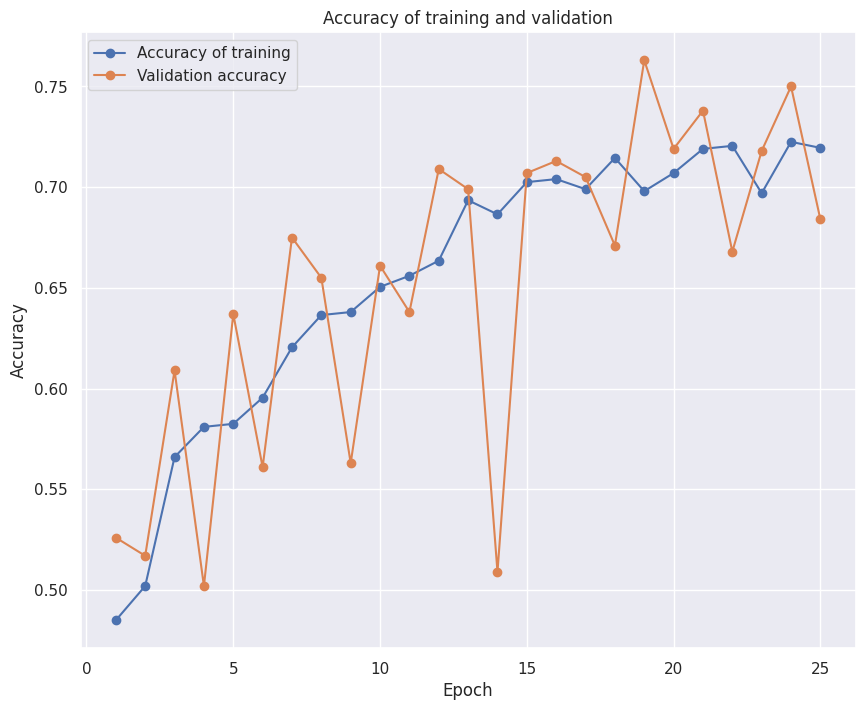

In [ ]:
make_accuracy_plot(history)

**# Wykres strat dla danych treninowych  i walidacji**

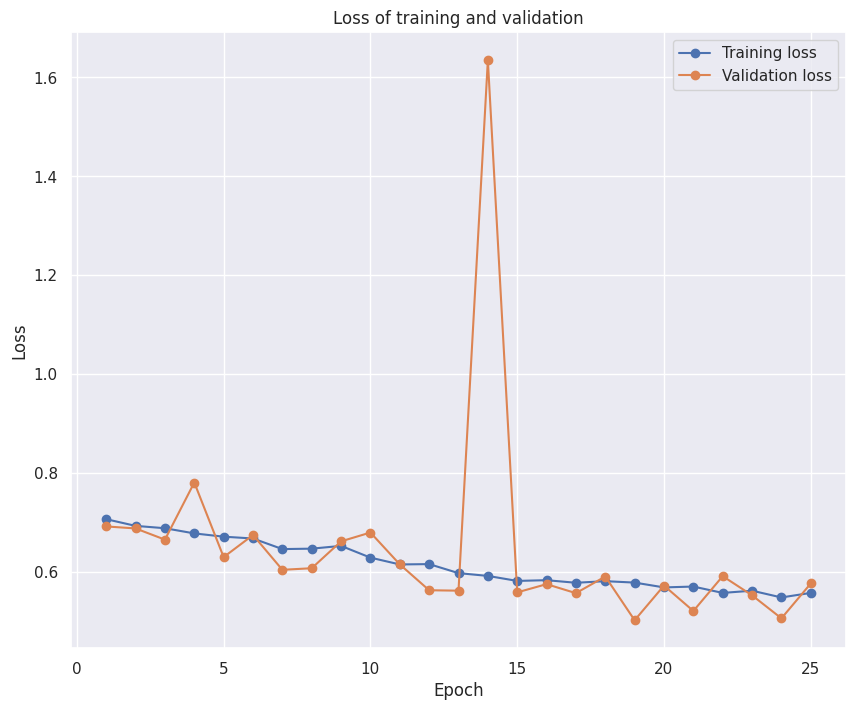

In [ ]:
make_loss_plot(history)

In [ ]:
# dane walidacyjne są wyłczone z tego procesu !!!
test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_directory(test_dir,
                                                 target_size=(150, 150),
                                                 batch_size=20,
                                                 class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('Testing Accuracy:', test_acc)

Found 1000 images belonging to 2 classes.
Testing Accuracy: 0.6700000166893005


**#########################################################################**


**# Transfer Learning**

Opiera się na wykorzystaniu już przetrenowanego modelu, zwykle na bardzo dużym zestawie danych wejściowych,

Wykorzystamy architekturę modelu VGG16 (zawierającego 16 warstw) wytrenowanego na zbiorze `Imagenet`.

Kolekcja Imagenet składa się z 1,4 miliona obrazów podzielonych na 1000 klas, które obejmują również różne rasy psów i kotów.

Gotowy model jest dostępny w bibliotece Keras.

In [ ]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(150, 150, 3))

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

**# Budowa modelu**

Do zaimportowanego modelu dodajemy  trzy nowe warstwy :
warstwę Flatten i dwie warstwy gęste (Dense).

In [ ]:
from keras import models
from keras import layers


model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dense(units=1, activation='sigmoid'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_7 (Flatten)         (None, 8192)              0         
                                                                 
 dense_14 (Dense)            (None, 256)               2097408   
                                                                 
 dense_15 (Dense)            (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 2097665 (8.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


**# Proces uczenia model ( z zamrożonymi warstwami konwolucyjnymi z zaimportowanego modelu)**

Zamrozimy teraz wagi sieci VGG16, aby zapobiec ich aktualizacji w procesie uczenia.



In [ ]:
# zamrażamy zaimportowany model (jego warstwy)
conv_base.trainable = False
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_7 (Flatten)         (None, 8192)              0         
                                                                 
 dense_14 (Dense)            (None, 256)               2097408   
                                                                 
 dense_15 (Dense)            (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 2097665 (8.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


**# Etap augmentacji**

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers


train_datagen = ImageDataGenerator(rescale=1./255.,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

# dane walidacyjne są wyłczone z tego procesu !!!
test_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(150, 150),
                                                   batch_size=20,
                                                   class_mode='binary')
valid_generator = test_datagen.flow_from_directory(valid_dir,
                                                   target_size=(150, 150),
                                                   batch_size=20,
                                                   class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.



**# Kompilacja i szkolenie rozszerzonego modelu (z wyłączeniem warstw splotu)**


In [ ]:
model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
             loss='binary_crossentropy',
             metrics=['accuracy'])

history = model.fit_generator(train_generator,
                             steps_per_epoch=100,
                             epochs=50,
                             validation_data=valid_generator,
                             validation_steps=50,
                             verbose=2)

toc = time.time()
print('Czas procesu uczenia modelu: {}'.format(toc - tic))
model.save('wmi_small_model_1.h5')

Epoch 1/50
100/100 - 19s - loss: 0.3979 - accuracy: 0.8170 - val_loss: 0.3123 - val_accuracy: 0.8770 - 19s/epoch - 188ms/step
Epoch 2/50
100/100 - 18s - loss: 0.3921 - accuracy: 0.8215 - val_loss: 0.3059 - val_accuracy: 0.8830 - 18s/epoch - 175ms/step
Epoch 3/50
100/100 - 18s - loss: 0.3889 - accuracy: 0.8205 - val_loss: 0.3021 - val_accuracy: 0.8800 - 18s/epoch - 175ms/step
Epoch 4/50
100/100 - 18s - loss: 0.3891 - accuracy: 0.8265 - val_loss: 0.2979 - val_accuracy: 0.8810 - 18s/epoch - 176ms/step
Epoch 5/50
100/100 - 18s - loss: 0.3742 - accuracy: 0.8400 - val_loss: 0.2935 - val_accuracy: 0.8780 - 18s/epoch - 178ms/step
Epoch 6/50
100/100 - 20s - loss: 0.3685 - accuracy: 0.8345 - val_loss: 0.2890 - val_accuracy: 0.8780 - 20s/epoch - 197ms/step
Epoch 7/50
100/100 - 18s - loss: 0.3697 - accuracy: 0.8370 - val_loss: 0.2856 - val_accuracy: 0.8820 - 18s/epoch - 175ms/step
Epoch 8/50
100/100 - 20s - loss: 0.3664 - accuracy: 0.8345 - val_loss: 0.2827 - val_accuracy: 0.8830 - 20s/epoch - 197

**# Weryfikacja  dokładności modelu**

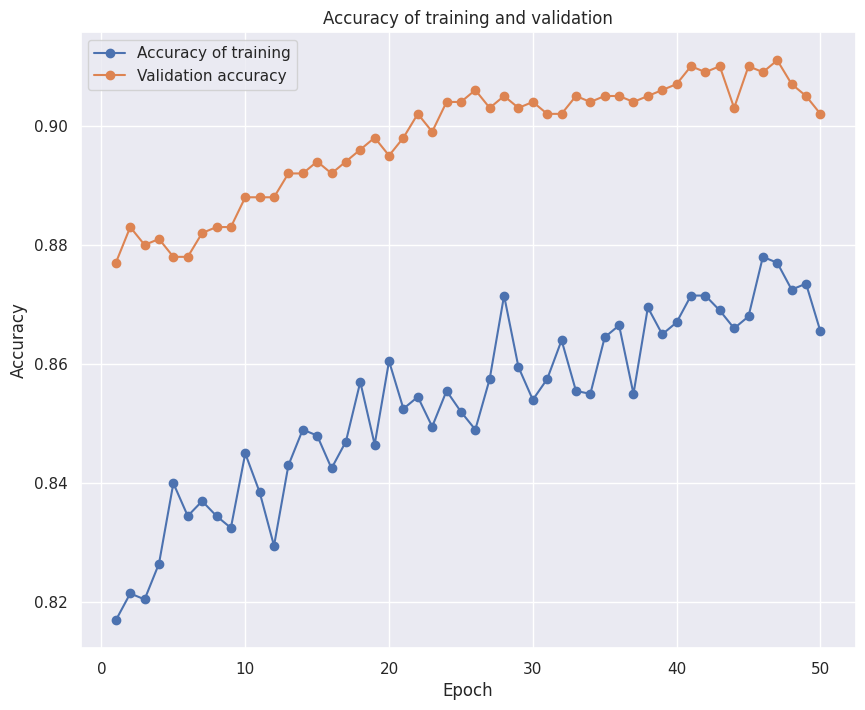

In [ ]:
make_accuracy_plot(history)

**# Rozkład funkcji strat**

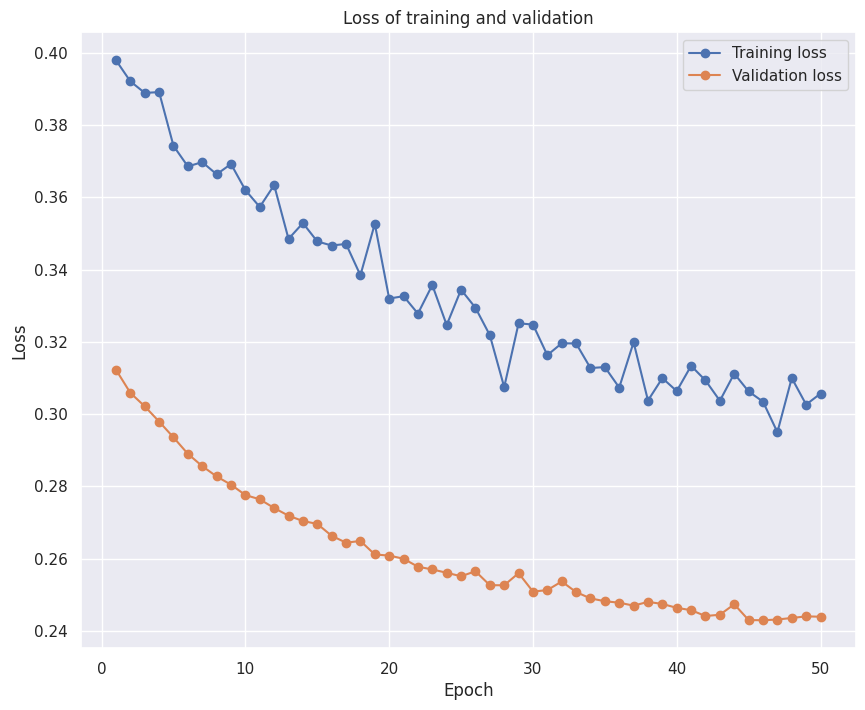

In [ ]:
make_loss_plot(history)

In [ ]:
test_generator = test_datagen.flow_from_directory(test_dir,
                                                 target_size=(150, 150),
                                                 batch_size=20,
                                                 class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('Testing Accuracy:', test_acc)

Found 1000 images belonging to 2 classes.
Testing Accuracy: 0.8889999985694885


**# Tuning modelu**



Technika ta polega na "odmrożeniu" kilku górnych warstw zamrożonej podstawy modelu.
Np. dostroimy trzy ostatnie warstwy konwolucyjne (`block5_conv1, block5_conv2, block5_conv3`).



In [ ]:
conv_base = VGG16(weights='imagenet',
                 include_top=False,    # whether to include the upper part of the network
                 input_shape=(150, 150, 3))

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
conv_base.trainable = True

def print_layers(model):
    for layer in model.layers:
        print('layer_name: {:12}, trainable: {}'.format(layer.name, layer.trainable))

print_layers(conv_base)

layer_name: input_3     , trainable: True
layer_name: block1_conv1, trainable: True
layer_name: block1_conv2, trainable: True
layer_name: block1_pool , trainable: True
layer_name: block2_conv1, trainable: True
layer_name: block2_conv2, trainable: True
layer_name: block2_pool , trainable: True
layer_name: block3_conv1, trainable: True
layer_name: block3_conv2, trainable: True
layer_name: block3_conv3, trainable: True
layer_name: block3_pool , trainable: True
layer_name: block4_conv1, trainable: True
layer_name: block4_conv2, trainable: True
layer_name: block4_conv3, trainable: True
layer_name: block4_pool , trainable: True
layer_name: block5_conv1, trainable: True
layer_name: block5_conv2, trainable: True
layer_name: block5_conv3, trainable: True
layer_name: block5_pool , trainable: True


In [ ]:
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

print_layers(conv_base)

layer_name: input_3     , trainable: False
layer_name: block1_conv1, trainable: False
layer_name: block1_conv2, trainable: False
layer_name: block1_pool , trainable: False
layer_name: block2_conv1, trainable: False
layer_name: block2_conv2, trainable: False
layer_name: block2_pool , trainable: False
layer_name: block3_conv1, trainable: False
layer_name: block3_conv2, trainable: False
layer_name: block3_conv3, trainable: False
layer_name: block3_pool , trainable: False
layer_name: block4_conv1, trainable: False
layer_name: block4_conv2, trainable: False
layer_name: block4_conv3, trainable: False
layer_name: block4_pool , trainable: False
layer_name: block5_conv1, trainable: True
layer_name: block5_conv2, trainable: True
layer_name: block5_conv3, trainable: True
layer_name: block5_pool , trainable: True


In [ ]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dense(units=1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=1e-5),
             loss='binary_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_8 (Flatten)         (None, 8192)              0         
                                                                 
 dense_16 (Dense)            (None, 256)               2097408   
                                                                 
 dense_17 (Dense)            (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 9177089 (35.01 MB)
Non-trainable params: 7635264 (29.13 MB)
_________________________________________________________________


**Wnioski**

    Konwolucyjne sieci neuronowe są najlepszymi modelami uczenia maszynowego do zadań przetwarzania obrazu.

    Sieci konwolucyjne mogą być trenowane nawet na małych zbiorach danych, w tym celu pomocne jest rozszerzanie danych i uczenie transferowe (przykład: zdjęcia medyczne).
    
    Możliwość wykorzystania uczenia transferowego pozwala na trenowanie modeli w znacznie krótszym czasie przy znacznie większej efektywności takiego modelu w porównaniu do modelu opartego jedynie na posiadanych przez nas
    danych.
    
    Techniki dostrajania pozwalają na dostosowanie wcześniej wyuczonych modeli do naszego problemu, co w rzeczywistości powinno prowadzić do poprawy wydajności modelu.
    
